<img src="static/images/datachain-logo.png" alt="Dataset" style="width: 200px;"/>

# 🚀 Run Inference Jobs using Datachain (scalable batch scoring)

In this tutorial, you'll learn how to run inference jobs on a large dataset using **[Datachain](https://github.com/iterative/datachain)** in batch processing. Batch inference is useful when you have a pre-trained model and want to make predictions on a dataset without needing real-time processing. **[Datachain](https://github.com/iterative/datachain)** provides a convenient way to run inference jobs on datasets stored in DataChain.

## 📋  Agenda

1. Load Pre-trained Model
2. Define Inference Classes
3. Run Inference
4. Save Predictions

## 🛠 Prerequisites

Before you begin, ensure you have:

- **[Datachain](https://github.com/iterative/datachain)** installed in your environment. 
- The necessary dependencies installed, including PyTorch and the required libraries.
- Access to the pre-trained model file `model.pth`.
- Access to the test dataset `fashion-test` for inference.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pathlib
import torch

from datachain import C, DataChain, DataModel
from datachain.lib.image import convert_image
from torch import optim

from src.train import CNN, transform

# 📥 Load Model (pre-trained)

- Load the pre-trained model weights and optimizer state.
- Create an instance of the `CNN` model.
- Create an optimizer using `optim.SGD`.


In [2]:
#### Load Pre-trained Model  #####

checkpoint = torch.load("model.pth")
CLASSES = checkpoint["classes"]
NUM_CLASSES = len(CLASSES)

model = CNN(NUM_CLASSES)
optimizer = optim.SGD(model.parameters(), lr=0.001)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

print(CLASSES)
print(NUM_CLASSES)
print(model, optimizer)

['Casual', 'Ethnic', 'Sports', 'Formal', 'Party', 'Smart Casual', 'Travel', 'nan']
8
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=8, bias=True)
) SGD (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    nesterov: False
    weight_decay: 0
)


/var/folders/28/ly259mjn413_8g33c4n20tvc0000gn/T/ipykernel_96018/1247583527.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model.pth")


By following these steps, you can easily load a pre-trained model and its associated optimizer state in PyTorch. This allows you to leverage the learned weights and continue training or perform inference without starting from scratch.

# ✅ Run Inference & Save Predictions

- Load the `fashion-test` dataset.
- Apply filters to select only 'Coffee' category images with non-empty `front_back` values.
- Use `map()` to apply the `InferenceMapper` to each image in the dataset.
- The `InferenceMapper` takes the image binary file as input and outputs the predicted class, probability, and label.
- The `save()` method is used to save the dataset with the predicted values as `fashion-predictions`.

## Define the inference classes

In [3]:
#### Inference #####

class Predictions(DataModel):
    pred_class: int
    pred_proba: float
    pred_label: str

class InferenceMapper():

    def __init__(self, model, classes):
        self.model = model
        self.classes = classes 
        
        self.model.eval()

    def predict(self, file) -> Predictions:

        img_raw = file.read()
        img = convert_image(img_raw, transform=transform).unsqueeze(0)
        
        with torch.no_grad():
            # emb = model(img)
            outputs = self.model(img)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_classes = torch.max(probs, 1)

        return Predictions(
            pred_class=predicted_classes.item(),
            pred_proba=confidence.item(),
            pred_label=self.classes[predicted_classes.item()]
        )

inference_eng = InferenceMapper(model, CLASSES) 

- Define a `Predictions` class that inherits from `DataModel` to store the predicted class, probability, and label.
- Define an `InferenceMapper` class to perform the inference logic.

## Run Inference

In [4]:
(
    DataChain.from_dataset("fashion-test")
    .limit(500) # Take a sample for the DEMO purposes
    .settings(parallel=-1)    
    .map(predictions=lambda file: inference_eng.predict(file), output=Predictions)
    .save("fashion-predictions")
    .show()
)

/Users/mikhailrozhkov/dev/datachain/datachain/examples/computer_vision/fashion_product_images/.venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

/Users/mikhailrozhkov/dev/datachain/datachain/examples/computer_vision/fashion_product_images/.venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

/Users/mikhailrozhkov/dev/datachain/datachain/examples/computer_vision/fashion_product_images/.venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

/Users/mikhailrozhkov/dev/datachain/datachain/examples/computer_vision/fashion_product_images/.venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

/Users/mikhailrozhkov/dev/datachain/datachain/examples/computer_vision/fashion_product_images/.venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

/Users/mikhailrozhkov/dev/datachain/datachain/examples/computer_vision/fashion_product_images/.venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

/Users/mikhailrozhkov/dev/datachain/datachain/examples/computer_vision/fashion_product_images/.venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

/Users/mikhailrozhkov/dev/datachain/datachain/examples/computer_vision/fashion_product_images/.venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

/Users/mikhailrozhkov/dev/datachain/datachain/examples/computer_vision/fashion_product_images/.venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

/Users/mikhailrozhkov/dev/datachain/datachain/examples/computer_vision/fashion_product_images/.venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

/Users/mikhailrozhkov/dev/datachain/datachain/examples/computer_vision/fashion_product_images/.venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

/Users/mikhailrozhkov/dev/datachain/datachain/examples/computer_vision/fashion_product_images/.venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

/Users/mikhailrozhkov/dev/datachain/datachain/examples/computer_vision/fashion_product_images/.venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

Download: 31.1kB [00:00, 230kB/s]
Download: 61.5kB [00:00, 223kB/s]
Processed: 6 rows [00:00, 47.07 rows/s]

Download: 84.2kB [00:00, 155kB/s]
Processed: 11 rows [00:00, 31.82 rows/s]
Processed: 16 rows [00:00, 30.65 rows/s]


Download: 115kB [00:00, 102kB/s] 
Processed: 25 rows [00:00, 31.97 rows/s]

Download: 138kB [00:01, 115kB/s]
Processed: 29 rows [00:00, 29.53 rows/s]
Processed: 33 rows [00:01, 26.62 rows/s]

Download: 151kB [00:01, 91.5kB/s]
Download: 168kB [00:01, 105kB/s] 


Download: 232kB [00:01, 164kB/s] 
Processed: 50 rows [00:01, 32.30 rows/s]


Download: 256kB [00:02, 130kB/s]
Processed: 58 rows [00:01, 29.93 rows/s]

Download: 310kB [00:02, 189kB/s]
Processed: 64 rows [00:02, 33.45 rows/s]
Processed: 68 rows [00:02, 28.97 rows/s]


Processed: 73 rows [00:02, 31.13 rows/s]
Download: 333kB [00:02, 112kB/s]


Processed: 83 rows [00:02, 31.89 rows/s]
Processed: 87 rows [00:02, 28.45 rows/s]

Download: 357kB [00:03, 91.0kB/s]
Download: 399kB [00:03, 130kB/s] 
Processed: 94 rows [00:03, 29.59 rows/s]

Download: 455kB [00:03, 180kB/s]
Download: 518kB [00:03, 246kB/s]
Processed: 102 rows [00:03, 30.35 rows/s]

Download: 557kB [00:03, 250kB/s]
Download: 623kB [00:03, 281kB/s]
Processed: 110 rows [00:03, 26.42 rows/s]

Download: 684kB [00:04, 340kB/s]
Download: 736kB [00:04, 350kB/s]
Processed: 118 rows [00:03, 27.90 rows/s]

Download: 781kB [00:04, 364kB/s]
Download: 822kB [00:04, 344kB/s]
Processed: 126 rows [00:04, 29.88 rows/s]


Processed: 131 rows [00:04, 33.96 rows/s]
Processed: 137 rows [00:04, 36.51 rows/s]

Download: 865kB [00:04, 217kB/s]
Processed: 141 rows [00:04, 32.73 rows/s]
Processed: 145 rows [00:04, 30.89 rows/s]

Download: 894kB [00:05, 182kB/s]
Processed: 149 rows [00:04, 30.58 rows/s]
Processed: 154 rows [00:05, 33.38 rows/s]

Download: 922kB [00:05, 133kB/s]
Download: 953kB [00:05, 152kB/s]
Processed: 162 rows [00:05, 27.63 rows/s]

Download: 996kB [00:05, 191kB/s]
Processed: 166 rows [00:05, 28.97 rows/s]
Processed: 170 rows [00:05, 29.13 rows/s]

Download: 1.00MB [00:06, 158kB/s]
Download: 1.03MB [00:06, 166kB/s]
Processed: 179 rows [00:05, 30.62 rows/s]


Download: 1.05MB [00:06, 133kB/s]
Processed: 187 rows [00:06, 28.71 rows/s]

Download: 1.10MB [00:06, 188kB/s]
Download: 1.13MB [00:06, 188kB/s]
Processed: 196 rows [00:06, 28.25 rows/s]

Download: 1.19MB [00:06, 264kB/s]
Processed: 200 rows [00:06, 30.16 rows/s]
Processed: 204 rows [00:06, 27.85 rows/s]


Download: 1.27MB [00:07, 220kB/s]
Processed: 216 rows [00:07, 35.05 rows/s]

Download: 1.30MB [00:07, 221kB/s]
Download: 1.33MB [00:07, 230kB/s]

Download: 1.39MB [00:07, 302kB/s]
Download: 1.45MB [00:07, 344kB/s]
Processed: 228 rows [00:07, 27.13 rows/s]

Download: 1.50MB [00:07, 390kB/s]
Processed: 234 rows [00:07, 33.29 rows/s]
Processed: 238 rows [00:07, 32.46 rows/s]


Download: 1.55MB [00:08, 233kB/s]
Processed: 246 rows [00:08, 30.69 rows/s]


Processed: 250 rows [00:08, 31.49 rows/s]
Processed: 254 rows [00:08, 32.90 rows/s]


Download: 1.58MB [00:08, 162kB/s]
Processed: 263 rows [00:08, 32.64 rows/s]


Download: 1.61MB [00:09, 159kB/s]
Processed: 271 rows [00:08, 32.58 rows/s]

Download: 1.63MB [00:09, 141kB/s]
Download: 1.65MB [00:09, 150kB/s]
Processed: 279 rows [00:09, 32.32 rows/s]


Processed: 283 rows [00:09, 29.86 rows/s]
Download: 1.67MB [00:09, 110kB/s]


Download: 1.69MB [00:10, 92.3kB/s]
Processed: 299 rows [00:09, 31.45 rows/s]


Download: 1.70MB [00:10, 82.6kB/s]
Processed: 307 rows [00:10, 29.20 rows/s]

Download: 1.72MB [00:10, 93.4kB/s]
Download: 1.74MB [00:10, 105kB/s] 
Processed: 316 rows [00:10, 34.11 rows/s]


Download: 1.75MB [00:10, 92.6kB/s]
Processed: 326 rows [00:10, 34.35 rows/s]


Download: 1.76MB [00:11, 73.2kB/s]
Download: 1.77MB [00:11, 78.9kB/s]


Download: 1.78MB [00:11, 69.8kB/s]
Download: 1.79MB [00:11, 73.1kB/s]


Download: 1.81MB [00:11, 76.4kB/s]
Processed: 354 rows [00:11, 32.02 rows/s]

Download: 1.83MB [00:11, 99.6kB/s]
Download: 1.84MB [00:11, 90.7kB/s]


Download: 1.85MB [00:12, 88.3kB/s]
Processed: 369 rows [00:11, 36.65 rows/s]

Download: 1.86MB [00:12, 81.8kB/s]
Processed: 373 rows [00:12, 34.58 rows/s]
Download: 1.87MB [00:12, 73.8kB/s]


Download: 1.88MB [00:12, 72.2kB/s]
Processed: 387 rows [00:12, 39.32 rows/s]

Download: 1.89MB [00:12, 70.4kB/s]
Download: 1.90MB [00:12, 73.9kB/s]


Download: 2.05MB [00:13, 289kB/s]
Processed: 402 rows [00:12, 30.32 rows/s]

Download: 2.08MB [00:13, 272kB/s]
Processed: 408 rows [00:13, 33.19 rows/s]
Processed: 413 rows [00:13, 34.51 rows/s]

Download: 2.11MB [00:13, 221kB/s]
Processed: 418 rows [00:13, 37.14 rows/s]
Download: 2.14MB [00:13, 218kB/s]


Processed: 426 rows [00:13, 36.78 rows/s]
Download: 2.16MB [00:13, 159kB/s]

Download: 2.18MB [00:14, 168kB/s]
Processed: 435 rows [00:13, 33.61 rows/s]
Processed: 439 rows [00:13, 34.22 rows/s]


Download: 2.20MB [00:14, 138kB/s]
Processed: 447 rows [00:14, 34.48 rows/s]


Download: 2.24MB [00:14, 127kB/s]
Processed: 458 rows [00:14, 38.03 rows/s]


Download: 2.25MB [00:14, 113kB/s]
Download: 2.31MB [00:14, 200kB/s]


Processed: 471 rows [00:14, 38.14 rows/s]
Processed: 475 rows [00:15, 31.79 rows/s]

Download: 2.34MB [00:15, 166kB/s]
Processed: 482 rows [00:15, 37.56 rows/s]


Download: 2.37MB [00:15, 139kB/s]
Download: 2.40MB [00:15, 169kB/s]

Download: 2.43MB [00:15, 183kB/s]
Download: 2.46MB [00:15, 179kB/s]

Download: 2.49MB [00:16, 157kB/s]
Processed: 500 rows [00:16, 30.50 rows/s]


,file,file,file,file,file,file,file,file,file,file,gender,mastercategory,subcategory,articletype,basecolour,season,year,usage,productdisplayname,filename,split,predictions,predictions,predictions
,source,parent,name,size,version,etag,is_latest,last_modified,location,vtype,,,,,,,,,,,,pred_class,pred_proba,pred_label
0,gs://datachain-demo,fashion-product-images/images,10003.jpg,11564,1719489683599343,CO/fpJ7e+4YDEAE=,1,2024-06-27 12:01:23.651000+00:00,None,,Women,Apparel,Topwear,Tshirts,White,Fall,2011.0,Sports,Nike Women As Nike Eleme White T-Shirt,10003.jpg,test,0,0.886476,Casual
1,gs://datachain-demo,fashion-product-images/images,10006.jpg,2146,1719489713329967,CK+uu6ze+4YDEAE=,1,2024-06-27 12:01:53.379000+00:00,None,,Men,Apparel,Topwear,Tshirts,Black,Fall,2011.0,Sports,Nike Men AS T90 Black Tshirts,10006.jpg,test,0,0.814388,Casual
2,gs://datachain-demo,fashion-product-images/images,10009.jpg,17019,1719489513563157,CJXIms3d+4YDEAE=,1,2024-06-27 11:58:33.614000+00:00,None,,Men,Apparel,Topwear,Tshirts,Red,Fall,2011.0,Sports,Nike Men Town Round Red Neck T-Shirts,10009.jpg,test,0,0.952003,Casual
3,gs://datachain-demo,fashion-product-images/images,10010.jpg,14601,1719489733476370,CJKAibbe+4YDEAE=,1,2024-06-27 12:02:13.521000+00:00,None,,Men,Apparel,Topwear,Tshirts,Black,Fall,2011.0,Sports,Nike Men As Showdown F Black T-Shirts,10010.jpg,test,0,0.873535,Casual
4,gs://datachain-demo,fashion-product-images/images,10017.jpg,15516,1719489683394315,CIuemJ7e+4YDEAE=,1,2024-06-27 12:01:23.451000+00:00,None,,Women,Apparel,Topwear,Jackets,Blue,Fall,2011.0,Sports,Nike Women As The Windru Blue Jackets,10017.jpg,test,0,0.578153,Casual
5,gs://datachain-demo,fashion-product-images/images,10019.jpg,2503,1719489605320971,CIuC+/jd+4YDEAE=,1,2024-06-27 12:00:05.371000+00:00,None,,Women,Apparel,Topwear,Tshirts,White,Fall,2011.0,Sports,Nike Women As Miler Ss White T-Shirts,10019.jpg,test,0,0.657133,Casual
6,gs://datachain-demo,fashion-product-images/images,10042.jpg,13461,1719489403029758,CP6RwJjd+4YDEAE=,1,2024-06-27 11:56:43.082000+00:00,None,,Women,Apparel,Topwear,Tshirts,Pink,Fall,2011.0,Sports,Nike Women Pink Polo Tshirts,10042.jpg,test,0,0.966780,Casual
7,gs://datachain-demo,fashion-product-images/images,10051.jpg,2169,1719489449603712,CIDl2q7d+4YDEAE=,1,2024-06-27 11:57:29.654000+00:00,None,,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Puma Men Motorsport Navy Blue Shirts,10051.jpg,test,0,0.999992,Casual
8,gs://datachain-demo,fashion-product-images/images,10057.jpg,2289,1719489389823049,CMmImpLd+4YDEAE=,1,2024-06-27 11:56:29.868000+00:00,None,,Men,Apparel,Topwear,Tshirts,White,Fall,2011.0,Casual,Puma Men Tshirt Trning White Polo Tshirts,10057.jpg,test,0,0.999759,Casual



[Limited by 20 rows]


## Explore predictions

In [5]:
DataChain.from_dataset("fashion-predictions").select("predictions").show(10)

,predictions,predictions,predictions
,pred_class,pred_proba,pred_label
0,0,0.886476,Casual
1,0,0.814388,Casual
2,0,0.952003,Casual
3,0,0.873535,Casual
4,0,0.578153,Casual
5,0,0.657133,Casual
6,0,0.966780,Casual
7,0,0.999992,Casual
8,0,0.999759,Casual



[Limited by 10 rows]


In [6]:
DataChain.from_dataset("fashion-predictions").to_pandas().shape

(500, 24)

## Delta Updates 

- Assume we already calculated predictions for 'old' dataset (for this example assume it's all images added before 2017)
- The 'new' dataset contains some images added after 2017
- We want to calculate inference for this delta updates only

In [7]:
# Prepare datasets

old = (
    DataChain.from_dataset("fashion-product-images")
    .filter(C("masterCategory") == "Apparel" and C("subCategory") == "Topwear")
    .filter(C("year") < 2018)
    # .limit(3)
)
print(old.to_pandas().shape)

new = (
    DataChain.from_dataset("fashion-product-images")
    .filter(C("masterCategory") == "Apparel" and C("subCategory") == "Topwear")
)
print(new.to_pandas().shape)

update = new.subtract(old)
print(update.to_pandas().shape)


(21335, 20)
(21395, 20)


(60, 20)


In [8]:
update_predictions = (
    update
    .map(predictions=lambda file: inference_eng.predict(file), output=Predictions)
    .save()
)

df = update_predictions.to_pandas()
print(df.shape)
df.head()

Download: 0.00B [00:00, ?B/s]

/Users/mikhailrozhkov/dev/datachain/datachain/examples/computer_vision/fashion_product_images/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processed: 0 rows [00:00, ? rows/s]

Download: 22.6kB [00:00, 40.7kB/s]

Processed: 2 rows [00:00,  4.34 rows/s]

Download: 45.3kB [00:01, 47.2kB/s]

Processed: 3 rows [00:00,  3.14 rows/s]

Download: 53.3kB [00:01, 33.5kB/s]

Processed: 4 rows [00:01,  2.65 rows/s]

Download: 71.8kB [00:02, 33.7kB/s]

Processed: 5 rows [00:01,  2.27 rows/s]

Download: 93.5kB [00:02, 38.9kB/s]

Processed: 6 rows [00:02,  2.26 rows/s]

Download: 101kB [00:02, 33.5kB/s] 

Processed: 7 rows [00:02,  2.33 rows/s]

Download: 114kB [00:03, 30.3kB/s]

Processed: 8 rows [00:03,  2.18 rows/s]

Download: 122kB [00:03, 26.2kB/s]

Processed: 9 rows [00:03,  2.16 rows/s]

Download: 140kB [00:04, 30.1kB/s]

Processed: 10 rows [00:04,  2.15 rows/s]

Download: 162kB [00:04, 36.4kB/s]

Processed: 11 rows [00:04,  2.16 rows/s]

Download: 181kB [00:05, 36.0kB/s]

Processed: 12 rows [00:05,  2.06 rows/s]

Download: 204kB [00:05, 40.7kB/s]

Processed: 13 rows [00:05,  2.10 rows/s]

Download: 218kB [00:06, 32.8kB/s]

Processed: 14 rows [00:06,  1.84 rows/s]

Download: 238kB [00:07, 34.6kB/s]

Processed: 15 rows [00:06,  1.87 rows/s]

Download: 257kB [00:07, 37.8kB/s]

Processed: 16 rows [00:07,  2.00 rows/s]

Download: 265kB [00:07, 34.1kB/s]

Processed: 17 rows [00:07,  2.18 rows/s]

Download: 287kB [00:08, 36.7kB/s]

Processed: 18 rows [00:08,  2.08 rows/s]

Download: 298kB [00:08, 35.0kB/s]

Processed: 19 rows [00:08,  2.21 rows/s]

Download: 322kB [00:09, 41.3kB/s]

Processed: 20 rows [00:09,  2.23 rows/s]

Download: 344kB [00:09, 47.6kB/s]

Processed: 21 rows [00:09,  2.42 rows/s]

Download: 349kB [00:09, 39.4kB/s]

Processed: 22 rows [00:09,  2.58 rows/s]

Download: 357kB [00:10, 34.2kB/s]

Processed: 23 rows [00:10,  2.60 rows/s]

Download: 374kB [00:10, 39.7kB/s]

Processed: 24 rows [00:10,  2.76 rows/s]

Download: 379kB [00:10, 33.2kB/s]

Processed: 25 rows [00:10,  2.84 rows/s]

Download: 387kB [00:11, 30.0kB/s]

Processed: 26 rows [00:11,  2.82 rows/s]

Download: 406kB [00:11, 36.7kB/s]

Processed: 27 rows [00:11,  2.78 rows/s]

Download: 424kB [00:11, 41.4kB/s]

Processed: 28 rows [00:11,  2.80 rows/s]

Download: 432kB [00:12, 34.9kB/s]

Processed: 29 rows [00:12,  2.73 rows/s]

Download: 454kB [00:12, 43.4kB/s]

Processed: 30 rows [00:12,  2.75 rows/s]

Download: 470kB [00:12, 45.3kB/s]

Processed: 31 rows [00:12,  2.84 rows/s]

Download: 478kB [00:13, 37.7kB/s]

Processed: 32 rows [00:13,  2.76 rows/s]

Download: 503kB [00:13, 47.5kB/s]

Processed: 33 rows [00:13,  2.75 rows/s]

Download: 516kB [00:14, 43.7kB/s]

Processed: 34 rows [00:14,  2.72 rows/s]

Download: 537kB [00:14, 48.1kB/s]

Processed: 35 rows [00:14,  2.73 rows/s]

Download: 553kB [00:14, 49.6kB/s]

Processed: 36 rows [00:14,  2.87 rows/s]

Download: 561kB [00:15, 40.1kB/s]

Processed: 37 rows [00:15,  2.74 rows/s]

Download: 587kB [00:15, 50.5kB/s]

Processed: 38 rows [00:15,  2.80 rows/s]

Download: 605kB [00:15, 48.9kB/s]

Processed: 39 rows [00:15,  2.67 rows/s]

Download: 631kB [00:16, 56.2kB/s]

Processed: 40 rows [00:16,  2.70 rows/s]

Processed: 41 rows [00:16,  2.78 rows/s]

Download: 641kB [00:16, 38.2kB/s]

Processed: 42 rows [00:16,  2.82 rows/s]

Processed: 43 rows [00:17,  2.88 rows/s]

Download: 650kB [00:17, 28.8kB/s]

Processed: 44 rows [00:17,  2.91 rows/s]

Download: 658kB [00:18, 27.5kB/s]

Processed: 45 rows [00:17,  2.88 rows/s]

Download: 675kB [00:18, 32.0kB/s]

Processed: 46 rows [00:18,  2.81 rows/s]

Download: 693kB [00:18, 37.5kB/s]

Processed: 47 rows [00:18,  2.85 rows/s]

Download: 701kB [00:19, 33.7kB/s]

Processed: 48 rows [00:18,  2.85 rows/s]

Download: 715kB [00:19, 36.9kB/s]

Processed: 49 rows [00:19,  2.96 rows/s]

Processed: 50 rows [00:19,  3.02 rows/s]

Download: 726kB [00:20, 27.7kB/s]

Processed: 51 rows [00:19,  2.88 rows/s]

Download: 746kB [00:20, 34.7kB/s]

Processed: 52 rows [00:20,  2.84 rows/s]

Download: 751kB [00:20, 30.7kB/s]

Processed: 53 rows [00:20,  2.91 rows/s]

Download: 756kB [00:21, 25.2kB/s]

Processed: 54 rows [00:21,  2.85 rows/s]

Download: 764kB [00:21, 21.8kB/s]

Processed: 55 rows [00:21,  2.48 rows/s]

Download: 779kB [00:22, 27.0kB/s]

Processed: 56 rows [00:21,  2.47 rows/s]

Download: 792kB [00:22, 30.0kB/s]

Processed: 57 rows [00:22,  2.61 rows/s]

Download: 800kB [00:22, 27.2kB/s]

Processed: 58 rows [00:22,  2.58 rows/s]

Download: 819kB [00:23, 35.3kB/s]

Processed: 59 rows [00:23,  2.70 rows/s]

Download: 827kB [00:23, 32.0kB/s]

Processed: 60 rows [00:23,  2.75 rows/s]

Download: 841kB [00:23, 36.7kB/s]


Processed: 60 rows [00:23,  2.57 rows/s]

(60, 23)


file                                                   \
                source                         parent       name   size   
0  gs://datachain-demo  fashion-product-images/images  53534.jpg  14994   
1  gs://datachain-demo  fashion-product-images/images  53467.jpg  25750   
2  gs://datachain-demo  fashion-product-images/images  27401.jpg   5681   
3  gs://datachain-demo  fashion-product-images/images  27960.jpg  18899   
4  gs://datachain-demo  fashion-product-images/images  27430.jpg  26377   

                                                 \
            version              etag is_latest   
0  1719489521026227  CLOJ4tDd+4YDEAE=         1   
1  1719489709624082  CJKW2are+4YDEAE=         1   
2  1719489455154209  CKHIrbHd+4YDEAE=         1   
3  1719489812400294  CKaR2tve+4YDEAE=         1   
4  1719489801643843  CMPOydbe+4YDEAE=         1   

                                                   ... articletype  \
                     last_modified location vtype  ...               
0 2024-06-27 11:58:41.078000+00:00     None        ...      Briefs   
1 2024-06-27 12:01:49.682000+00:00     None        ...         Bra   
2 2024-06-27 11:57:35.205000+00:00     None        ...         Bra   
3 2024-06-27 12:03:32.452000+00:00     None        ...       Trunk   
4 2024-06-27 12:03:21.696000+00:00     None        ...     Tshirts   

     basecolour  season    year   usage  \
                                          
0          Grey  Summer  2018.0  Casual   
1         Black  Summer  2018.0  Casual   
2         White  Summer  2018.0  Casual   
3         Black  Summer  2018.0  Casual   
4  Grey Melange  Summer  2018.0  Casual   

                                  productdisplayname   filename predictions  \
                                                                 pred_class   
0           Amante Women Grey Seamless Briefs PCSN11  53534.jpg           0   
1                 Amante Black Balconette Bra BCMW11  53467.jpg           0   
2  Jockey White Solid Non-Wired Non-Padded Cross ...  27401.jpg           0   
3     Jockey SPORT PERFORMANCE Men Black Trunks SP08  27960.jpg           0   
4             Jockey Women Grey Melange T-shirt 1359  27430.jpg           0   

                         
  pred_proba pred_label  
0   0.962574     Casual  
1   0.999915     Casual  
2   0.999899     Casual  
3   0.873528     Casual  
4   0.903043     Casual  

[5 rows x 23 columns]

In [9]:
# Size of Predictions before the union (old)

DataChain.from_dataset("fashion-predictions").to_pandas().shape

(500, 24)

In [10]:
# Add (union) new predictions and save (as a new version)

(
    DataChain.from_dataset("fashion-predictions")
    .union(update_predictions)
    .save("fashion-predictions")
)

In [11]:
# Size of Predictions after union

DataChain.from_dataset("fashion-predictions").to_pandas().shape

(560, 24)

# 🔍 Analyze Predictions

After running inference on your test dataset and generating predictions, it's crucial to analyze the results to gain insights into your model's performance. 

DataChain provides powerful tools to filter and examine the predictions, allowing you to identify correct predictions, incorrect predictions, and explore different confidence levels. Let's break down the code:

## Show correct predictions

- Load the "fashion-predictions" dataset, which contains the predicted labels and probabilities along with the ground truth labels.
- Filter the dataset to include only the correct predictions where the predicted label (`pred_label`) matches the ground truth label (`usage`).

In [12]:
# Show correct predictions

(
    DataChain.from_dataset("fashion-predictions")
    .filter(C("usage") == C("predictions").pred_label)
    .show(5)
)

,file,file,file,file,file,file,file,file,file,file,gender,mastercategory,subcategory,articletype,basecolour,season,year,usage,productdisplayname,filename,split,predictions,predictions,predictions
,source,parent,name,size,version,etag,is_latest,last_modified,location,vtype,,,,,,,,,,,,pred_class,pred_proba,pred_label
0,gs://datachain-demo,fashion-product-images/images,10051.jpg,2169,1719489449603712,CIDl2q7d+4YDEAE=,1,2024-06-27 11:57:29.654000+00:00,None,,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Puma Men Motorsport Navy Blue Shirts,10051.jpg,test,0,0.999992,Casual
1,gs://datachain-demo,fashion-product-images/images,10057.jpg,2289,1719489389823049,CMmImpLd+4YDEAE=,1,2024-06-27 11:56:29.868000+00:00,None,,Men,Apparel,Topwear,Tshirts,White,Fall,2011.0,Casual,Puma Men Tshirt Trning White Polo Tshirts,10057.jpg,test,0,0.999759,Casual
2,gs://datachain-demo,fashion-product-images/images,10061.jpg,2116,1719489795724626,CNKq4NPe+4YDEAE=,1,2024-06-27 12:03:15.784000+00:00,None,,Men,Apparel,Topwear,Tshirts,White,Fall,2011.0,Casual,Puma Men graphic story tee White Tshirts,10061.jpg,test,0,0.999864,Casual
3,gs://datachain-demo,fashion-product-images/images,10062.jpg,1262,1719489765967616,CICOyMXe+4YDEAE=,1,2024-06-27 12:02:46.026000+00:00,None,,Men,Apparel,Topwear,Tshirts,Grey,Fall,2011.0,Casual,Puma Men Puma runhard tee Grey Tshirts,10062.jpg,test,0,0.993904,Casual
4,gs://datachain-demo,fashion-product-images/images,10063.jpg,2308,1719489778207313,CNGUs8ve+4YDEAE=,1,2024-06-27 12:02:58.258000+00:00,None,,Men,Apparel,Topwear,Tshirts,Yellow,Fall,2011.0,Casual,Puma Men spine tee Yellow Tshirts,10063.jpg,test,0,0.999984,Casual



[Limited by 5 rows]


## Show incorrect predictions

- Filter the dataset to include only the incorrect predictions where the predicted label (`pred_label`) does not match the ground truth label (`usage`).
- Assign the filtered dataset to the variable `mistakes`.

In [13]:
# Show incorrect predictions

mistakes = (
    DataChain.from_dataset("fashion-predictions")
    .filter(C("usage") != C("predictions").pred_label)
    .select("file", "usage", "predictions")
    .save()
)
mistakes.show(5)

,file,file,file,file,file,file,file,file,file,file,usage,predictions,predictions,predictions
,source,parent,name,size,version,etag,is_latest,last_modified,location,vtype,,pred_class,pred_proba,pred_label
0,gs://datachain-demo,fashion-product-images/images,10003.jpg,11564,1719489683599343,CO/fpJ7e+4YDEAE=,1,2024-06-27 12:01:23.651000+00:00,None,,Sports,0,0.886476,Casual
1,gs://datachain-demo,fashion-product-images/images,10006.jpg,2146,1719489713329967,CK+uu6ze+4YDEAE=,1,2024-06-27 12:01:53.379000+00:00,None,,Sports,0,0.814388,Casual
2,gs://datachain-demo,fashion-product-images/images,10009.jpg,17019,1719489513563157,CJXIms3d+4YDEAE=,1,2024-06-27 11:58:33.614000+00:00,None,,Sports,0,0.952003,Casual
3,gs://datachain-demo,fashion-product-images/images,10010.jpg,14601,1719489733476370,CJKAibbe+4YDEAE=,1,2024-06-27 12:02:13.521000+00:00,None,,Sports,0,0.873535,Casual
4,gs://datachain-demo,fashion-product-images/images,10017.jpg,15516,1719489683394315,CIuemJ7e+4YDEAE=,1,2024-06-27 12:01:23.451000+00:00,None,,Sports,0,0.578153,Casual



[Limited by 5 rows]


(134, 14)


<Axes: >

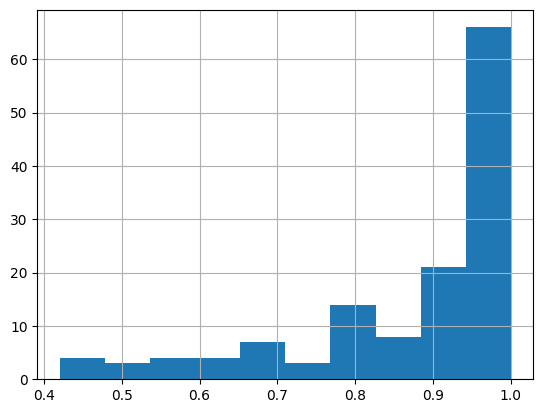

In [14]:
df = mistakes.to_pandas()
print(df.shape)

df["predictions"]["pred_proba"].hist()

## Analyze high-confidence and low-confidence mistakes

- Filter the `mistakes` dataset
    -  `high-confidence` are mistakes where the predicted probability (`pred_proba`) is more than 0.5.
    -  `low-confidence` are mistakes where the predicted probability (`pred_proba`) is less than 0.5.
- Order the filtered dataset by the predicted probability in ascending order using `order_by(C("pred_proba").asc())`.
- Convert the filtered and ordered dataset to a pandas DataFrame using `to_pandas()`.
- Print the shape of the resulting DataFrame to see the number of low-confidence mistakes.
- Display the first 3 low-confidence mistakes using `head(3)`.

In [15]:
mistakes.schema

{'file': datachain.lib.file.ImageFile,
 'usage': str,
 'predictions': __main__.Predictions}

In [16]:
# Find high-confidence mistakes

high_conf_mist =(
    mistakes
    .filter(C("predictions.pred_proba") > 0.85 )
    .order_by("predictions.pred_proba", descending=True)
)

print(high_conf_mist.to_pandas().shape)
high_conf_mist.show(5)

(92, 14)


,file,file,file,file,file,file,file,file,file,file,usage,predictions,predictions,predictions
,source,parent,name,size,version,etag,is_latest,last_modified,location,vtype,,pred_class,pred_proba,pred_label
0,gs://datachain-demo,fashion-product-images/images,53781.jpg,29848,1719489432531308,COziyKbd+4YDEAE=,1,2024-06-27 11:57:12.574000+00:00,None,,Sports,0,0.999998,Casual
1,gs://datachain-demo,fashion-product-images/images,16124.jpg,2288,1719489610417799,CIeNsvvd+4YDEAE=,1,2024-06-27 12:00:10.460000+00:00,None,,Sports,0,0.999994,Casual
2,gs://datachain-demo,fashion-product-images/images,12135.jpg,17831,1719489459796944,CND3yLPd+4YDEAE=,1,2024-06-27 11:57:39.841000+00:00,None,,Ethnic,0,0.999991,Casual
3,gs://datachain-demo,fashion-product-images/images,12141.jpg,2201,1719489619897486,CI7Z9P/d+4YDEAE=,1,2024-06-27 12:00:19.949000+00:00,None,,Ethnic,0,0.999989,Casual
4,gs://datachain-demo,fashion-product-images/images,14508.jpg,2168,1719489501810035,CPOazcfd+4YDEAE=,1,2024-06-27 11:58:21.862000+00:00,None,,Sports,0,0.999986,Casual



[Limited by 5 rows]


In [17]:
# Find low-confidence mistakes

low_conf_mist = (
    mistakes
    .filter(C("predictions.pred_proba") < 0.5 )
    .order_by("predictions.pred_proba", descending=False)
)

print(low_conf_mist.to_pandas().shape)
low_conf_mist.show(3)

(5, 14)


,file,file,file,file,file,file,file,file,file,file,usage,predictions,predictions,predictions
,source,parent,name,size,version,etag,is_latest,last_modified,location,vtype,,pred_class,pred_proba,pred_label
0,gs://datachain-demo,fashion-product-images/images,16138.jpg,1837,1719489743119709,CN3K1bre+4YDEAE=,1,2024-06-27 12:02:23.179000+00:00,None,,Casual,3,0.420481,Formal
1,gs://datachain-demo,fashion-product-images/images,12654.jpg,20643,1719489390141451,CIvArZLd+4YDEAE=,1,2024-06-27 11:56:30.195000+00:00,None,,Casual,2,0.457730,Sports
2,gs://datachain-demo,fashion-product-images/images,27399.jpg,13924,1719489452850068,CJT3oLDd+4YDEAE=,1,2024-06-27 11:57:32.910000+00:00,None,,Casual,3,0.467485,Formal



[Limited by 3 rows]


# 📊 Visualize mistakes

We can use `DataChain.collect()` to extract the values from the sample. Here's an example of collecting a subset of column signals from the sample:

In [18]:
sample_results = list(high_conf_mist.collect())
sample_results[0]

(ImageFile(source='gs://datachain-demo', parent='fashion-product-images/images', name='53781.jpg', size=29848, version='1719489432531308', etag='COziyKbd+4YDEAE=', is_latest=True, last_modified=datetime.datetime(2024, 6, 27, 11, 57, 12, 574000, tzinfo=datetime.timezone.utc), location=None, vtype=''),
 'Sports',
 Predictions(pred_class=0, pred_proba=0.9999980926513672, pred_label='Casual'))

The example has an output for each signal:
- `file` returns a special `ImageFile` object (see below).
- `usage` returns an original target class name
- `predictions` returns prediction data fields. 

DataChain knows to treat `file` as an `ImageFile` because we created the chain for the image files with `DataChain.from_storage(..., type="image")`. `ImageFile` is a "DataModel" in Datachain, and you can use `.read()` to get its value, which for `ImageFile` returns the image itself.

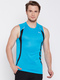

In [19]:
example = sample_results[0]
example[0].read()

In [20]:
# Prepare utility function to display sample results

import matplotlib.pyplot as plt
import numpy as np

def display_image_matrix(items, top):
    # Constants for the layout
    columns = 5
    rows = int(np.ceil(top / columns))

    # Create subplots
    fig, ax_arr = plt.subplots(rows, columns, figsize=(15, 3 * rows))
    fig.suptitle("Displaying images", fontsize=20)
    ax_arr = ax_arr.flatten() # Flatten the array of axes, in case of a single row

    # Plot images
    for i in range(top):
        if i < len(items):  # Check to avoid index error if less items than top
            img = items[i][0].read()  # Retrieve the image
            true_class = items[i][1]
            preds = items[i][2].model_dump()
            pred_class = preds['pred_label']

            # Set image and title
            ax_arr[i].imshow(img)
            ax_arr[i].set_title(f"True: {true_class}\nPred: {pred_class}", fontsize=14, backgroundcolor='white')
            ax_arr[i].axis('off')  # Hide axes
        else:
            ax_arr[i].axis('off')  # Hide unused subplots

    # Adjust layout and padding
    plt.tight_layout(pad=2.0)
    plt.show()

## Explore Low Confidence Mistakes

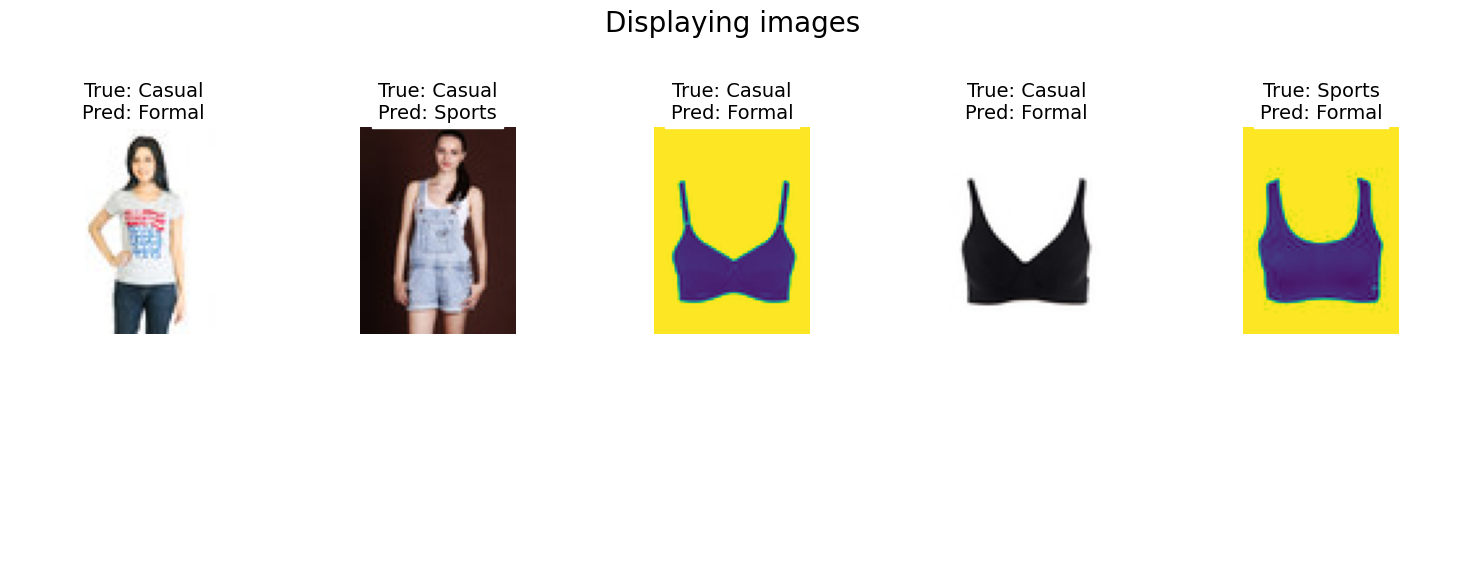

In [21]:
# Low Confidence Mistakes

TOP = 10
# for item in low_conf_mist.limit(TOP).collect():
#     display(item[0].read())
    
items = list(low_conf_mist.limit(TOP).collect())
display_image_matrix(items, TOP)

## Explore High Confidence Mistakes

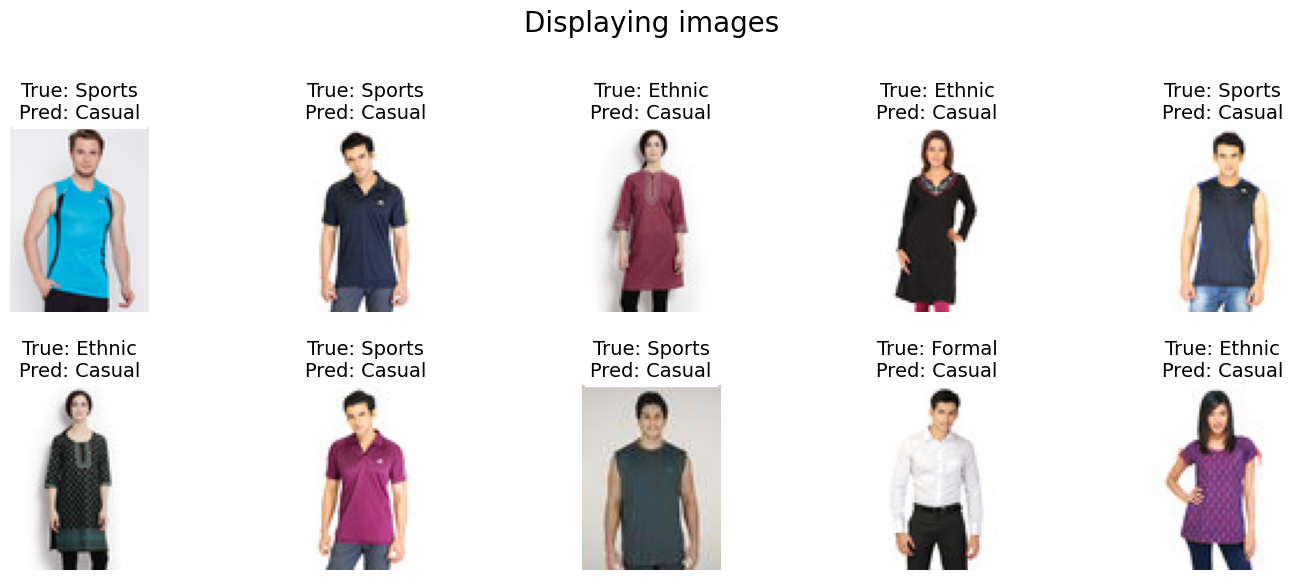

In [22]:
## How Confidence Mistakes

TOP = 10
# for item in high_conf_mist.limit(TOP).collect():
#     display(item[0].read())

items = list(high_conf_mist.limit(TOP).collect())
display_image_matrix(items, TOP)

## Explore Correct Predictions

In [23]:
correct_preds = (
    DataChain.from_dataset("fashion-predictions")
    .filter(C("usage") == C("predictions.pred_label"))
    .order_by("predictions.pred_proba", descending=True)
    .select("file", "usage", "predictions")
)

print(correct_preds.to_pandas().shape)
correct_preds.show(5)

(426, 14)


,file,file,file,file,file,file,file,file,file,file,usage,predictions,predictions,predictions
,source,parent,name,size,version,etag,is_latest,last_modified,location,vtype,,pred_class,pred_proba,pred_label
0,gs://datachain-demo,fashion-product-images/images,11355.jpg,16436,1719489778220882,CNL+s8ve+4YDEAE=,1,2024-06-27 12:02:58.273000+00:00,None,,Casual,0,1.0,Casual
1,gs://datachain-demo,fashion-product-images/images,10825.jpg,2028,1719489729942737,CNGpsbTe+4YDEAE=,1,2024-06-27 12:02:09.997000+00:00,None,,Casual,0,1.0,Casual
2,gs://datachain-demo,fashion-product-images/images,11448.jpg,25727,1719489620079473,CPHm///d+4YDEAE=,1,2024-06-27 12:00:20.129000+00:00,None,,Casual,0,1.0,Casual
3,gs://datachain-demo,fashion-product-images/images,11396.jpg,2512,1719489776329305,CNnEwMre+4YDEAE=,1,2024-06-27 12:02:56.385000+00:00,None,,Casual,0,1.0,Casual
4,gs://datachain-demo,fashion-product-images/images,11451.jpg,2043,1719489640419324,CPyf2Yne+4YDEAE=,1,2024-06-27 12:00:40.459000+00:00,None,,Casual,0,1.0,Casual



[Limited by 5 rows]


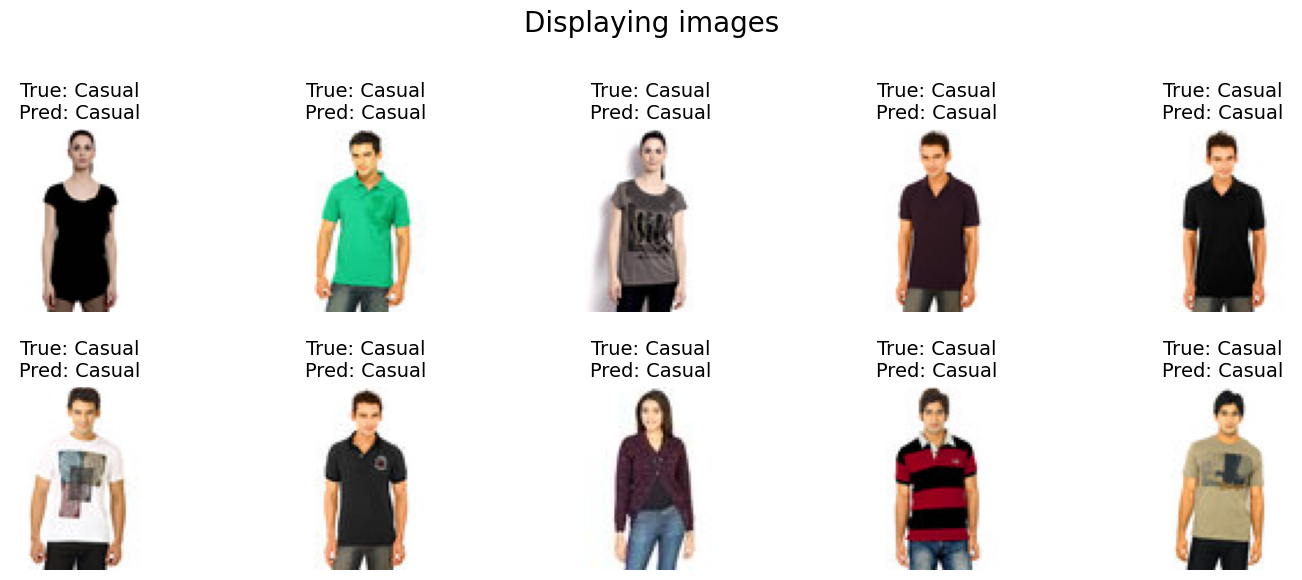

In [24]:
TOP = 10
# for item in high_conf_mist.limit(TOP).collect():
#     display(item[0].read())

items = list(correct_preds.limit(TOP).collect())
display_image_matrix(items, TOP)

# ☁️ Run in Studio (SaaS)

<a href="https://datachain.ai/">
    <img src="static/images/studio.png" alt="DataChain Studio SaaS" style="width: 600px;"/>
</a>

To run these examples in Studio, follow the guide.

1. Open Studio / YOUR_TEAM / `datasets` workspace
2. Create a new Python Script
3. Copy/paste scripts from this Jupyter Notebook
4. Specify Settings:
   - Computer vision dependencies
   - pre-trained model `model.pth`
   - import `train.py` module
5. Click the Run button


# 🎉 Summary 

**🌟 Congratulations! You've Successfully Completed the Inference Jobs with DataChain Tutorial! 🌟**

In this tutorial, you've gained a wealth of knowledge and skills that will elevate your computer vision projects to new heights. Let's recap the key topics covered:

1. 🔍 **Running Inference:** You unleashed the power of your model to make predictions on real-world fashion images.
2. 📊 **Saving Predictions:** You discovered how to save model predictions, probabilities, and true labels into a DataChain dataset for further analysis.
3. 🔍 **Analyzing Predictions:** You explored DataChain's querying and filtering capabilities to identify correct predictions, high-confidence mistakes, and low-confidence mistakes, gaining valuable insights into your model's performance.


Once again, congratulations on your incredible achievement! 

## What's Next?

Keep exploring, experimenting, and pushing the boundaries of what's possible in computer vision.  Check out the next parts of our tutorial series:
- 📚 Check other tutorials and User Guides
- 🔍 Try DataChain on your projects

By mastering these techniques, you'll be well on your way to building powerful and efficient computer vision pipelines with DataChain.

## Get Involved

We'd love to have you join our growing community of DataChain users and contributors! Here's how you can get involved:
- ⭐ Give us a star on [GitHub](https://github.com/iterative/datachain) to show your support
- 🌐 Visit the [datachain.ai website](https://datachain.ai/) to learn more about our products and services
- 📞 Contact us to discuss how DataChain can help streamline your company's ML workflows
- 🙌 Follow us on social media for the latest updates and insights

Thanks for choosing DataChain, and happy coding! 😄